<a href="https://colab.research.google.com/github/nadavavrahami/LDA/blob/main/LDA_company_peers_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install relevant libraries

In [ ]:
!pip install -q numpy
!pip install -q gensim
!pip install -q pynndescent>=4
!pip install -q umap-learn
!pip install -q hdbscan
!pip install -q wordcloud
!pip install -q tensorflow
!pip install -q tensorflow_hub
!pip install -q tensorflow_text
!pip install -q torch
!pip install -q sentence_transformers
!pip install -q hnswlib
!pip install -q joblib<1.0.0
!pip install -q bertopic
!pip install -q distributed==2021.9.0


     |████████████████████████████████| 80 kB 3.9 MB/s 
     |████████████████████████████████| 6.4 MB 5.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 4.4 MB 5.1 MB/s 
     |████████████████████████████████| 78 kB 3.6 MB/s 
     |████████████████████████████████| 2.9 MB 17.7 MB/s 
     |████████████████████████████████| 3.3 MB 40.6 MB/s 
     |████████████████████████████████| 1.2 MB 64.7 MB/s 
     |████████████████████████████████| 56 kB 4.5 MB/s 
     |████████████████████████████████| 895 kB 52.5 MB/s 
     |████████████████████████████████| 596 kB 72.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
/bin/bash: 1.0.0: No such file or directory
     |████████████████████████████████| 57 kB 2.7 MB/s 
     |████████████████████████████████| 13.2 MB 153 kB/s 
     |████████████

In [ ]:
!pip install -q top2vec[sentence_transformers]

In [1]:
!pip install nbconvert

# Import relevant libraries

In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('drive')
from scipy.spatial import distance_matrix
from sklearn.feature_extraction.text import  CountVectorizer
from textblob import TextBlob
import nltk
from sklearn.decomposition import LatentDirichletAllocation
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet')
from copy import deepcopy
from top2vec import Top2Vec
import numpy as np
from sklearn.datasets import fetch_20newsgroups
import matplotlib.pyplot as plt
import string

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
from bertopic import BERTopic
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import math

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        word_tokenize_list = [t for t in word_tokenize(articles) if t not in string.punctuation]
        return [self.wnl.lemmatize(t) for t in word_tokenize_list]


# Import data set and prepare it 

Import data from DB - including remove None inputs

I fetch all the data into my DB from a financial data source API (Financial Modeling Prep - https://financialmodelingprep.com/developer/docs)

I didnt want to share the DB details so I deleted them and copy the data into a .csv file. You can see how I copied it at the commented lines bellow.

In [ ]:
# pip install pymongo[srv]

In [ ]:
# from pymongo import MongoClient

# client = MongoClient(host="XXXXXXXXXXXXXXXXXXXXXXXXXX")
# db = client.XXXXXXXXXXXX
# collection = db.XXXXXXXXXX
# company_list = list(collection.aggregate([
#     {
#         "$match":{
#             "profile.isActivelyTrading":True,
#             "profile.isEtf":False,
#             "profile.description": {"$ne":None},
#             "profile.description": {"$ne":""},
#             # "profile.country": "US",
#             # "profile.sector":"Communication Services",
#         }
#     },
#     { "$project": {
#         "_id": 0,
#         "symbol": "$profile.symbol",
#         "company_name": "$profile.companyName",
#         "industry": "$profile.industry",
#         "sector": "$profile.sector",
#         "fullTimeEmployees":"$profile.fullTimeEmployees",
#         "market_cap": "$profile.mktCap",
#         "currency":"$profile.currency",
#         "country":"$profile.country",
#         "description": "$profile.description"
#     }}
# ]))

# companies_profiles = pd.DataFrame(company_list)
# companies_profiles = companies_profiles[companies_profiles["symbol"].notnull()]
# companies_profiles = companies_profiles[companies_profiles["company_name"].notnull()]
# companies_profiles = companies_profiles[companies_profiles["industry"].notnull()]
# companies_profiles = companies_profiles[companies_profiles["sector"].notnull()]
# companies_profiles = companies_profiles[companies_profiles["fullTimeEmployees"].notnull()]
# companies_profiles = companies_profiles[companies_profiles["market_cap"].notnull()]
# companies_profiles = companies_profiles[companies_profiles["currency"].notnull()]
# companies_profiles = companies_profiles[companies_profiles["country"].notnull()]
# companies_profiles = companies_profiles[companies_profiles["description"].notnull()]
# companies_profiles = companies_profiles.reset_index()

In [ ]:
# companies_profiles.to_csv('data.csv')
# !cp data.csv "drive/My Drive/"

Import data data from .csv file.


In [ ]:
companies_profiles = pd.read_csv('drive/My Drive/data.csv')

List of the first 3 ompanies, in order to see the structure.

In [ ]:
companies_profiles[:3]

Unnamed: 0  index  ... country                                        description
0           0      0  ...      US  Comcast Corporation operates as a media and te...
1           1      1  ...      US  Kinder Morgan, Inc. operates as an energy infr...
2           2      2  ...      US  Intel Corporation designs, manufactures, and s...

[3 rows x 11 columns]

## Data Preparations

I add to the data frame 4 fields that could help us understand the data better and also filter the results in a better way.

***Fields that will help us filter the data for better results:***

employees_range - rank that describes the amount of employees according to the legend

employees_range - rank that describes the companie's market cap according to the legend


***fields that will help us understant the data better:***

description_len - description amount of letters

description_word_count - description amount of words



In [ ]:
companies_profiles['employees_range'] = companies_profiles['fullTimeEmployees'].apply(lambda x: 0 if x==0 else 1 if x < 100  else 2 if x < 1000 else 3 if x < 10000 else 4 if x < 50000 else 5 if x >= 50000 else 0)
companies_profiles['market_cap_range'] = companies_profiles['market_cap'].apply(lambda x: 0 if x==0 else 1 if x < 100000000  else 2 if x < 500000000 else 3 if x < 1000000000 else 4 if x < 10000000000 else 5 if x < 50000000000 else 6 if x < 100000000000 else 7 if x >= 100000000000 else 0)
companies_profiles['description_len'] = companies_profiles['description'].astype(str).apply(len).apply(lambda x: '0: None' if x==0 else '1: less then 300' if x < 300 else '2: 300 to 600' if x < 600 else '3: 600 to 900' if x < 900 else '4: 900 to 1200' if x < 1200 else '5: 1200 to 1500' if x < 1500 else '6: more then 1500' if x >= 1500 else '0: None')
companies_profiles['description_word_count'] = companies_profiles['description'].apply(lambda x: len(str(x).split())).apply(lambda x: '0: None' if x==0 else '1: less then 50' if x < 50 else '2: 50 to 100' if x < 100 else '3: 100 to 150' if x < 150 else '4: 150 to 200' if x < 200 else '5: 200 to 250' if x < 250 else '6: more then 250' if x >= 250 else ': None')

In [ ]:
# function that fix string corruptions at sector and industry fields
def remove_nonletters(x):
    # remove known string corruptions
    string_corruptions = ["sâ€", " - ", "-"," & ", "&", ".", ",", "   ", "  ","—"," — "]
    for item in string_corruptions:
        x = x.replace(item, ' ')

    if x == ' ':
        x = ''

    # add spaces in case 2 words are connected
    for i in range(len(x)-2):
        if x[i].islower() and x[i+1].isupper():
            x = f'{x[:i+1]} {x[i+1:]}'
            
    return x

# EDA

The following section contains exporation of the data set.

I also added my own notes and conclusions

In [ ]:
print("the amount of companies is: {}".format(companies_profiles.count()['symbol']))

the amount of companies is: 20154


## Explore companies' data

In [ ]:
# function that create plot for relevant 
def create_count_plot(col, original_values_col=None, sort_by = 'y'):
  companies_profiles[col] = companies_profiles[col].apply(lambda x: remove_nonletters(x) if isinstance(x,str) else x )
  gruopby_col = companies_profiles.groupby(col).count()['symbol'].reset_index(name="count")
  if sort_by== 'x' :
    gruopby_col = gruopby_col.sort_index()
    if original_values_col:
      print("{} average: {}".format(original_values_col,str(companies_profiles[original_values_col].mean())))
      print("{} median: {}".format(original_values_col,str(companies_profiles[original_values_col].median())))
  else:
    gruopby_col = gruopby_col.sort_values('count',ascending=False)
    print("{} average: {}".format(col,str(gruopby_col["count"].mean())))
    print("{} median: {}".format(col,str(gruopby_col["count"].median())))
    print("{} max: {}".format(col,str(gruopby_col["count"].max())))
    items_count = gruopby_col["count"].count()
    print("{} amount: {}".format(col,str(items_count)))
    print("sum of top 10% items: {}".format(str(gruopby_col.nlargest(int(math.ceil(items_count*0.1)), 'count')["count"].sum())))
  col_plot = gruopby_col.plot(kind='bar', figsize=(32,8))
  col_plot.set_xticklabels(gruopby_col[col])
  col_plot

As you can see in the following 2 graphs, the division to industry and sector create not-proportional groups, with top 10% items that contains critical amout of the companies in both divisions.

Another thing I notice is that there are many industries with overlapping meaning, for examples - 

softeware services - internet software services - business software services

These graphs emphasis the need of defining similarity between comapnies in better way. 

industry average: 101.13020833333333
industry median: 63.0
industry max: 1116
industry amount: 192
sum of top 10% items: 8341


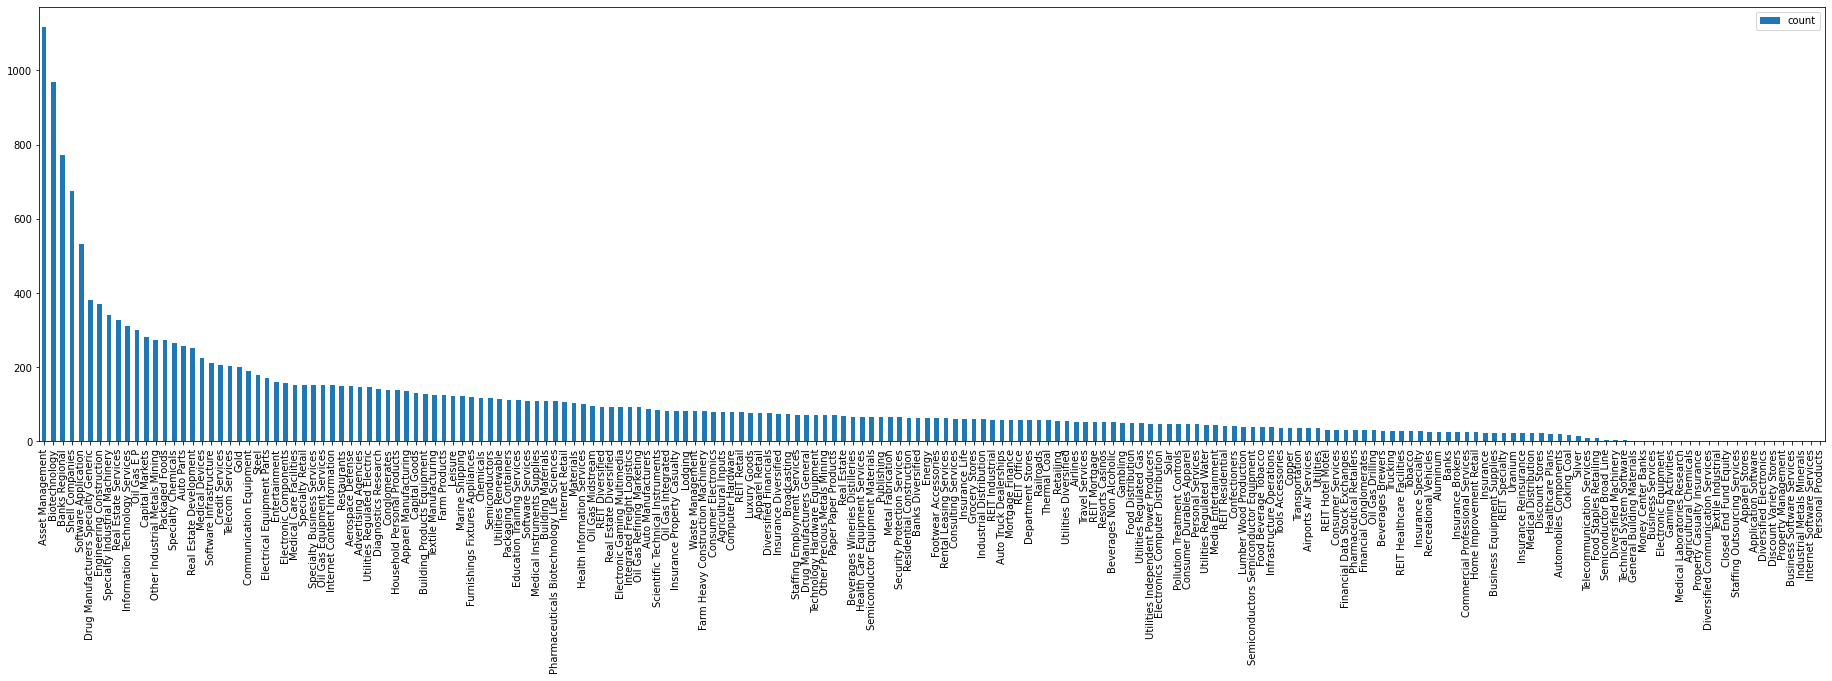

In [ ]:
create_count_plot('industry')

sector average: 355.24528301886795
sector median: 131.0
sector max: 2965
sector amount: 53
sum of top 10% items: 10762


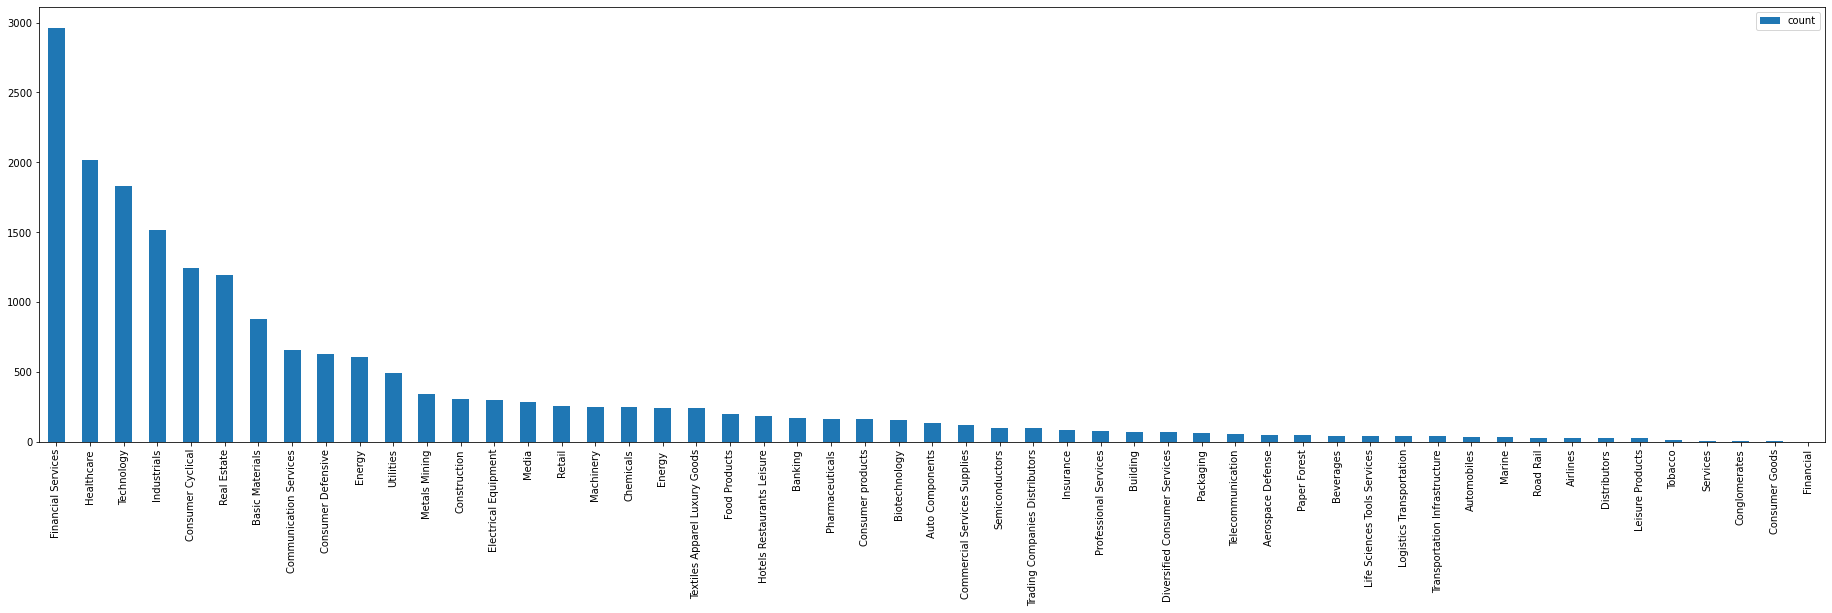

In [ ]:
create_count_plot('sector')

The most dominant market in the data set is the US market, but still more then 50% of the companies are from other countries. It is a thing that we need to consider and maybe use it.

country average: 223.93333333333334
country median: 16.5
country max: 7803
country amount: 90
sum of top 10% items: 16867


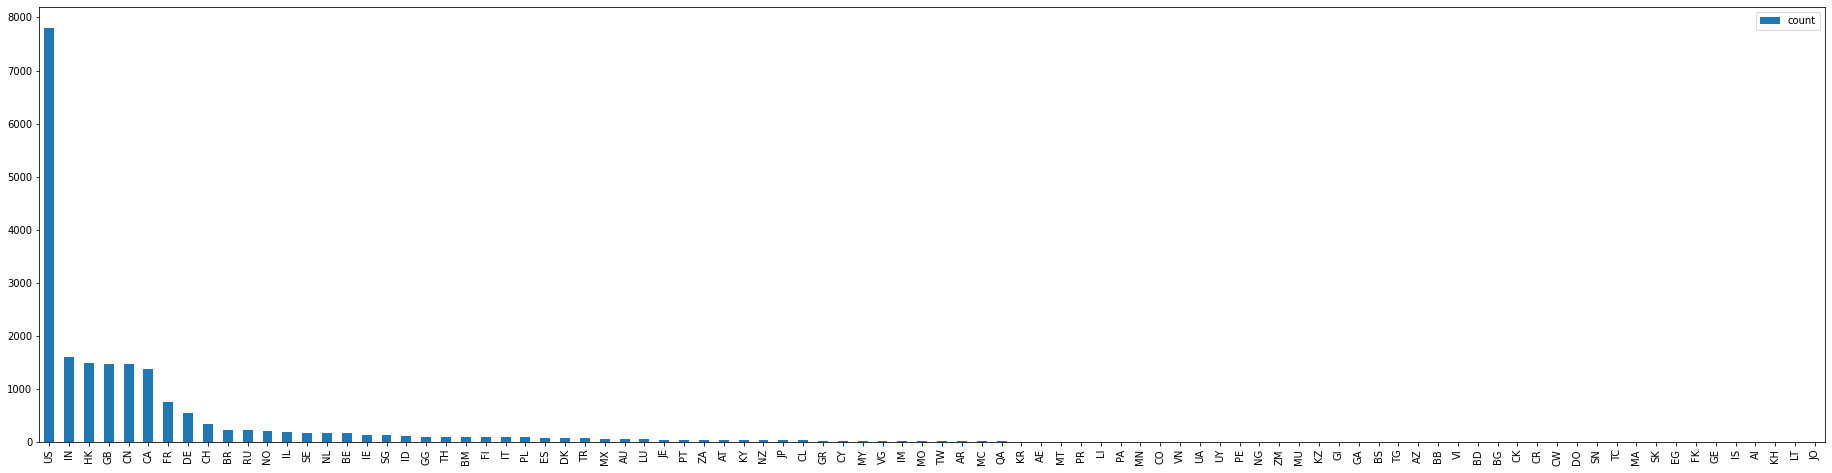

In [ ]:
create_count_plot('country')

currency average: 629.78125
currency median: 87.5
currency max: 8527
currency amount: 32
sum of top 10% items: 14891


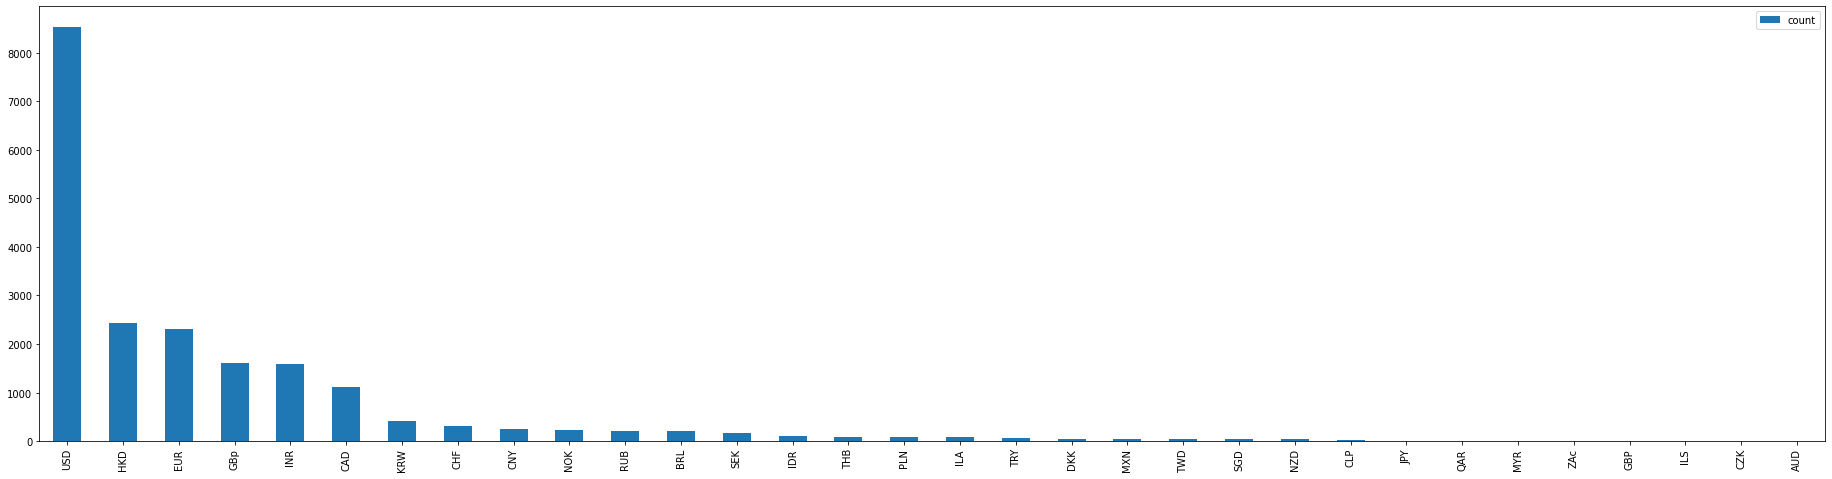

In [ ]:
create_count_plot('currency')

The following 2 graphs tag companies' size by employees and market cap.

Size is a metric that we would like to add to our algorithwm when we look for similar companies.

It is hard to say that companies with significant size difference are similar.

In [ ]:
employees_range_legend = {0: 'None', 1 : 'less then 100', 2: '100 to 1000', 3: '1000 to 10000', 4: '10000 to 50000', 5: 'more then 50000'}
employees_range_legend

{0: 'None',
 1: 'less then 100',
 2: '100 to 1000',
 3: '1000 to 10000',
 4: '10000 to 50000',
 5: 'more then 50000'}

fullTimeEmployees average: 11482.573944870182
fullTimeEmployees median: 817.0


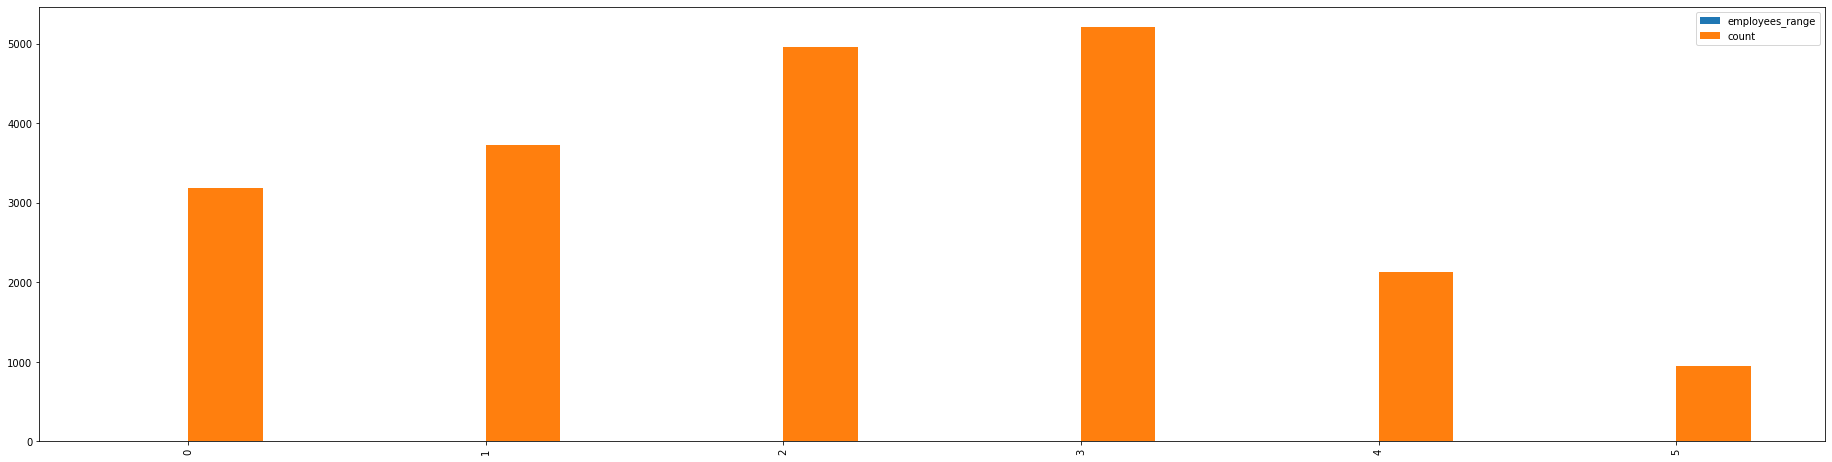

In [ ]:
create_count_plot('employees_range', original_values_col='fullTimeEmployees', sort_by="x")

In [ ]:
market_cap_range_legend = {0: 'None', 1 : 'less then 100M', 2: '100M to 500M', 3: '500M to 1B', 4: '1B to 10B', 5: '10B to 50B', 6: '50B to 100B', 7: 'more then 100B'}
market_cap_range_legend

{0: 'None',
 1: 'less then 100M',
 2: '100M to 500M',
 3: '500M to 1B',
 4: '1B to 10B',
 5: '10B to 50B',
 6: '50B to 100B',
 7: 'more then 100B'}

market_cap average: 1009038260395.9
market_cap median: 1021620448.0


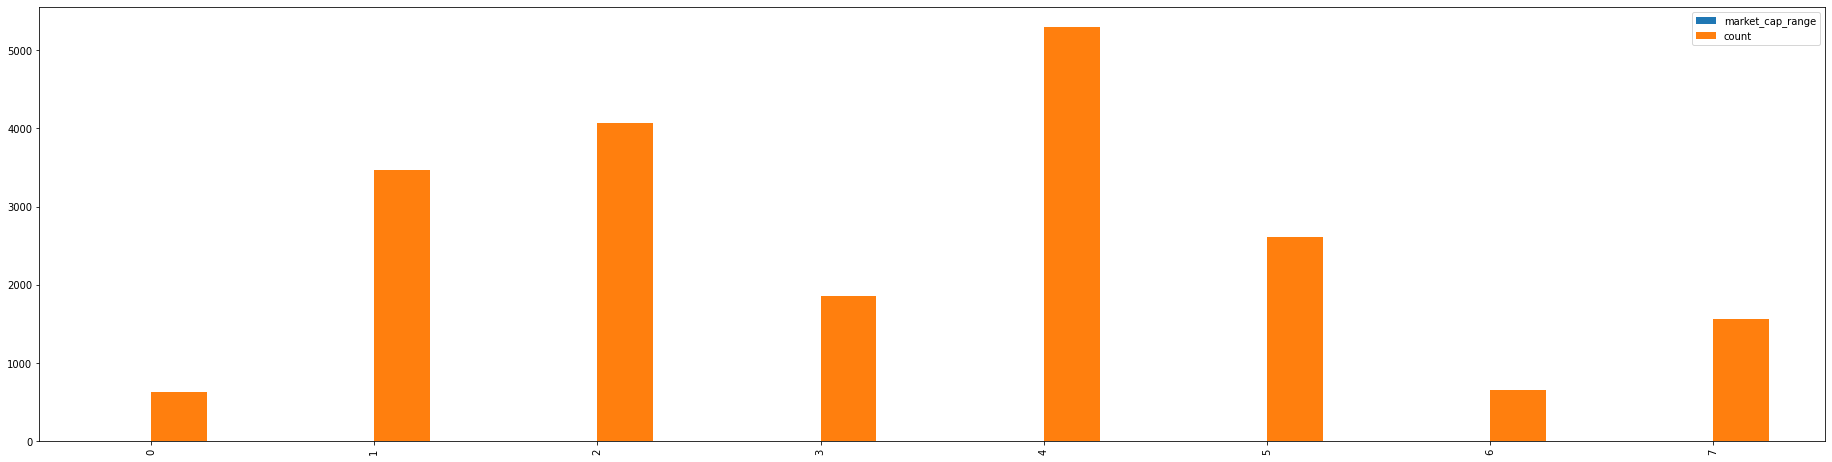

In [ ]:
create_count_plot('market_cap_range', original_values_col='market_cap', sort_by='x')

## Explore model inputs data

This part help us to know how the descriptions are look like.

The descriptions are the the inputs for the model so these are important graphs.

We can see that most of the descriptions have more then 100 words which is a good thing, and the length of most of them is 600+.

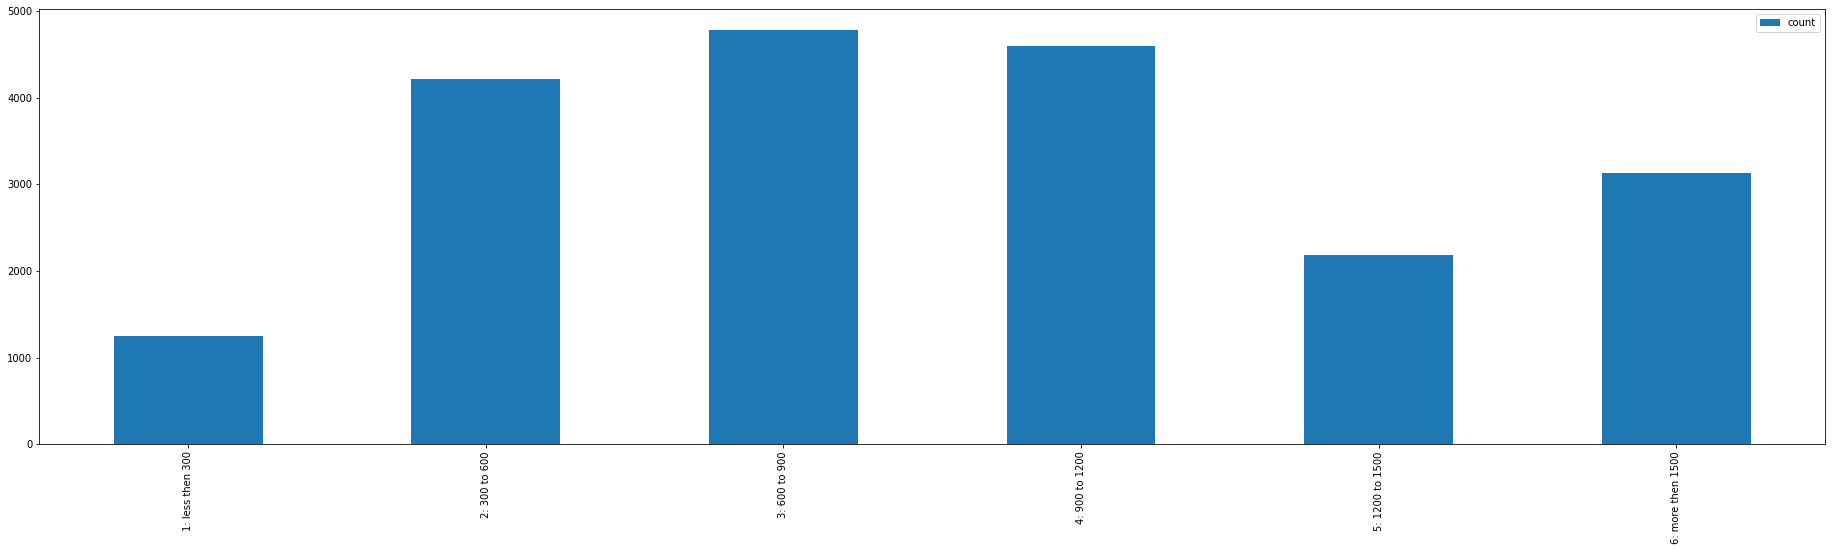

In [ ]:
create_count_plot('description_len', sort_by='x')

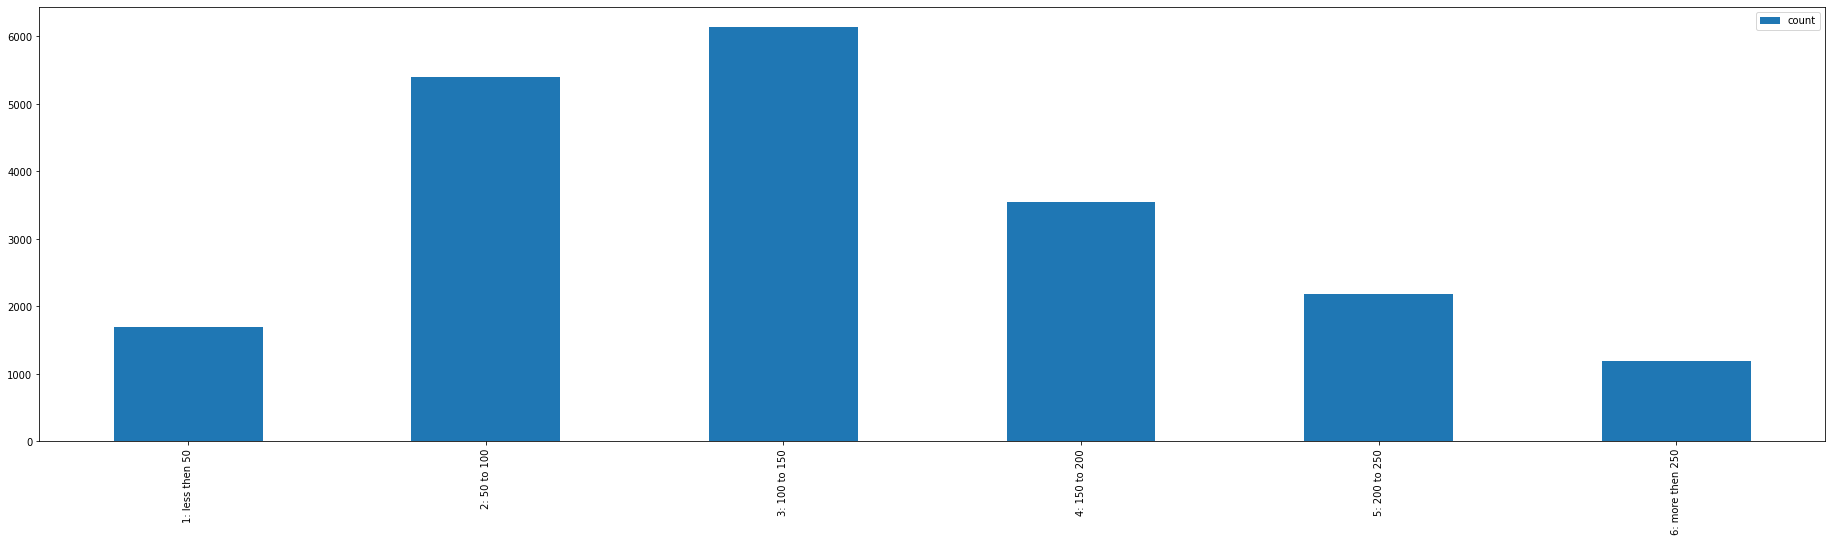

In [ ]:
create_count_plot('description_word_count', sort_by='x')

In [ ]:
def top_n_phrases_plot(phrase_size = 1 ,stop_words=None):
  vec = CountVectorizer(ngram_range=(phrase_size, phrase_size), stop_words=stop_words, tokenizer=LemmaTokenizer())
  bag_of_words = vec.fit_transform(companies_profiles['description'])
  sum_words = bag_of_words.sum(axis=0) 
  words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
  words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
  common_phrases = words_freq[:50]
  stop_phrases_distribution = {}
  for phrase in common_phrases:
    stop_phrases_distribution[phrase[0]] = phrase[1]
  wordcloud = WordCloud(width=3000,height=3000).generate_from_frequencies(stop_phrases_distribution)
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()

visualization of frequency of words and phrases in the takes. the dominant phrases are related to companies and businesses. The important part is the last one.

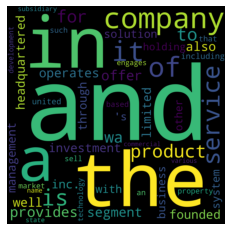

In [ ]:
top_n_phrases_plot(phrase_size = 1 ,stop_words=None)

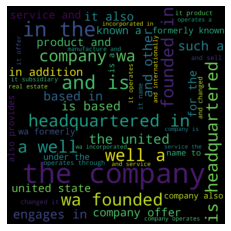

In [ ]:
top_n_phrases_plot(phrase_size = 2 ,stop_words=None)

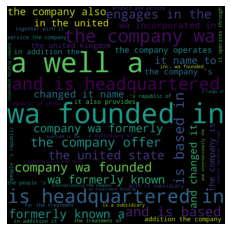

In [ ]:
top_n_phrases_plot(phrase_size = 3 ,stop_words=None)

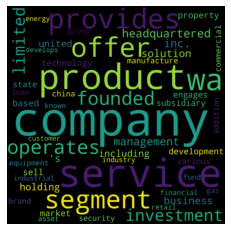

In [ ]:
top_n_phrases_plot(phrase_size = 1 ,stop_words='english')

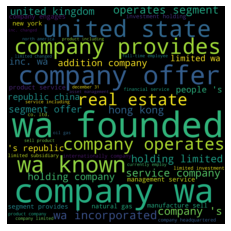

In [ ]:
top_n_phrases_plot(phrase_size = 2 ,stop_words='english')

In [ ]:
top_n_phrases_plot(phrase_size = 3 ,stop_words='english')

Here I look for the appropriate rate of appearance of words in thet texts so that the words would be relevance to the model, the meaning is to take out all the general words to let the words that unique to the segments of activity to be more dominant. Surprisingly the rate is very low and stands at 22%. Such a lesson takes out of the lexicon only about 26 words and indeed it can be seen that they are quite generic words.

In [ ]:
corpus = companies_profiles['description']
cnt_vec = CountVectorizer(min_df=0.22, stop_words='english',strip_accents = 'unicode', lowercase = True, tokenizer=LemmaTokenizer())
bag_of_words = cnt_vec.fit_transform(corpus)
sum_words = bag_of_words.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in cnt_vec.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
words_freq

[('company', 52870),
 ('service', 35153),
 ('product', 27911),
 ('wa', 20276),
 ('provides', 16641),
 ('offer', 15791),
 ('segment', 14284),
 ('operates', 13230),
 ('founded', 12244),
 ('investment', 12163),
 ('limited', 12092),
 ('headquartered', 11994),
 ('inc.', 11660),
 ('management', 11342),
 ('business', 9697),
 ("'s", 9379),
 ('including', 8174),
 ('united', 8042),
 ('based', 7068),
 ('sell', 6764),
 ('market', 6708),
 ('engages', 6261),
 ('subsidiary', 6234),
 ('state', 5962),
 ('addition', 5165),
 ('known', 4655)]

# LDA


CountVectorizer - Used to turn a body of text into a vector of term counts. It also provides the ability to process your text data before creating the vector representation and makes it a particularly flexible feature representation module for text. I also add here a lemmatization function.

Tokenization, cleaning stop words and removing uninformative words


In [ ]:
cnt_vec = CountVectorizer(max_df=0.22,min_df=2,stop_words='english',tokenizer=LemmaTokenizer())

We will create a matrix of frequencies of all the words in the documents and unify words by meanings

In [ ]:
doc_word_metrix = cnt_vec.fit_transform(companies_profiles['description'])
doc_word_metrix

I use LatentDirichletAllocation module from sklearn. I give it 140 component as input, means it will generate 140 topics. The random state is just for get permanent results between iterations.

In [ ]:
lda = LatentDirichletAllocation(n_components=140,random_state=42)

In [ ]:
lda.fit(doc_word_metrix)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=140, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

## LDA Results

The "topic_words" matrix contains all the distributions of words in each topic. 

The"decsription_topic" matrix contains the distributions of all topics in each text. 

In [ ]:
topic_words = lda.components_

In [ ]:
topic_words.shape

(140, 34494)

In [ ]:
decsription_topic = lda.transform(doc_word_mstrix)

In [ ]:
decsription_topic.shape

(20154, 140)

### Output representation

A group of common words in each of the topics.

We can see that the topics some of the topics are informative, and we could tag them easiely - 

Topic #1 => jewelries

Topic #3 => south america

Topic #4 => software

Topic #5 => transportation

Topic #2 is pretty general, bet we should remember the each text consists of few topics.

In [ ]:
for i, t in enumerate(topic_words):
  if i == 5:
    break
  print('Topic #{}'.format(i+1))
  print([cnt_vec.get_feature_names()[j] for j in t.argsort()[-10:]][::-1])
  print('\n')

Topic #1
['brand', 'jewelry', 'world', 'art', 'expressway', 'culture', 'best', 'handbag', 'retail', 'group']


Topic #2
['firm', 'employee', 'employ', 'full-time', 'currently', 'engaged', 'include', 'provision', 'includes', 'operation']


Topic #3
['chile', 'argentina', 'copper', 'brazil', 'peru', 'zinc', 'mexico', 'colombia', 'concentrate', 'australia']


Topic #4
['data', 'platform', 'solution', 'customer', 'software', 'application', 'information', 'enables', 'analytics', 'technology']


Topic #5
['logistics', 'transportation', 'freight', 'container', 'cargo', 'port', 'transport', 'warehousing', 'terminal', 'chain']




A vector that represente the "volume" of each topic in a given description, as I said, each text consists of few topics.

In [ ]:
decsription_topic[249].round(2)

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.09, 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.02, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.2 , 0.11, 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.08, 0.  , 0.  , 0.  , 0.  , 0.44, 0.  , 0.  , 0.01, 0.  , 0.  ,
       0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

## Check similarity based on description's topic vector.

Calculate vectors distances matrixs.



Each row or column represent a company, the value in cell(A,B) is the destance betweem company A vector to company B vector.



The assumption is that low distance means textual similarity

In [ ]:
doc_distance_matrix = distance_matrix(decsription_topic,decsription_topic)

Checking result for one company - Tasla



In [ ]:
selected_comapy_index = 249
feilds = ['symbol',	'company_name',	'industry',	'sector',	'description','employees_range','market_cap_range']

In [ ]:
selected_comapy = companies_profiles.iloc[[selected_comapy_index]]
selected_comapy

Unnamed: 0  index  ... description_word_count distance_from_selected
249         249    252  ...          4: 150 to 200               0.932828

[1 rows x 16 columns]

In [ ]:
companies_profiles['distance_from_selected'] = doc_distance_matrix[selected_comapy_index]
newdf = companies_profiles[feilds+['distance_from_selected']].iloc[doc_distance_matrix[selected_comapy_index].argsort()]
newdf = newdf[(newdf.distance_from_selected > 0)]
newdf = newdf[(newdf.market_cap_range > 0)]
newdf = newdf[(newdf.market_cap_range >= selected_comapy.iloc[0]['market_cap_range']-1)]
newdf = newdf[(newdf.market_cap_range <= selected_comapy.iloc[0]['market_cap_range']+1)]
newdf = newdf[(newdf.employees_range > 0)]
newdf = newdf[(newdf.employees_range >= selected_comapy.iloc[0]['employees_range']-1)]
newdf = newdf[(newdf.employees_range <= selected_comapy.iloc[0]['employees_range']+1)]
peers_list_len = 30
newdf[:6]

symbol  ... distance_from_selected
11863  FEES.ME  ...               0.354143
19708    ENLAY  ...               0.378471
296        DUK  ...               0.405935
11176   0ID1.L  ...               0.405935
14940   DUK-PA  ...               0.405935
7087   IBE1.DE  ...               0.407619

[6 rows x 8 columns]

Unfortunately the model results are desappointing. Clearly electricity suppliers are not peers of Tesla. 

We can try to filter the result by sector and industry, and to get only companies in the same industry and sector as the choosen company. In that case, we will miss a lot of companies that are not in the same industry and sector.


In [ ]:
companies_profiles['distance_from_selected'] = doc_distance_matrix[selected_comapy_index]
newdf = companies_profiles[feilds+['distance_from_selected']].iloc[doc_distance_matrix[selected_comapy_index].argsort()]
newdf = newdf[(newdf.distance_from_selected > 0)]
newdf = newdf[(newdf.market_cap_range > 0)]
newdf = newdf[(newdf.market_cap_range >= selected_comapy.iloc[0]['market_cap_range']-1)]
newdf = newdf[(newdf.market_cap_range <= selected_comapy.iloc[0]['market_cap_range']+1)]
newdf = newdf[(newdf.employees_range > 0)]
newdf = newdf[(newdf.employees_range >= selected_comapy.iloc[0]['employees_range']-1)]
newdf = newdf[(newdf.employees_range <= selected_comapy.iloc[0]['employees_range']+1)]
newdf = newdf[(newdf.sector == selected_comapy.iloc[0]['sector'])]
newdf = newdf[(newdf.industry == selected_comapy.iloc[0]['industry'])]
peers_list_len = 30
newdf[:6]

symbol  ... distance_from_selected
14444        2333.HK  ...               0.509589
1571             HMC  ...               0.553287
19647       FROTO.IS  ...               0.554946
14446        2238.HK  ...               0.571245
16881  BAJAJ-AUTO.NS  ...               0.592367
16121        0489.HK  ...               0.617387

[6 rows x 8 columns]

View of the vector of the company and the most similar peer

In [ ]:
decsription_topic[selected_comapy_index].round(2)

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.09, 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.02, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.2 , 0.11, 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.08, 0.  , 0.  , 0.  , 0.  , 0.44, 0.  , 0.  , 0.01, 0.  , 0.  ,
       0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

In [ ]:
decsription_topic[doc_distance_matrix[selected_comapy_index].argsort()[0]].round(2)

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.09, 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.02, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.2 , 0.11, 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.08, 0.  , 0.  , 0.  , 0.  , 0.44, 0.  , 0.  , 0.01, 0.  , 0.  ,
       0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

# Top2Vec

Top 2 vec is a topic modeling model that works at the following way - 


1. Create a vector for each word or document based on its meaning, using 
Doc2Vec models and word embedding models.


2. Reduce dimensional embedding of document vectors using UMAP.


3. Find dense areas of documents using HDBSCAN.


4. Calculate topic vector by Calculating the centroid of document vectors in original dimension.


5. Find closest words to the topic vector.


In [ ]:
descriptions = list(companies_profiles.iloc[:]['description'].values)

In [ ]:
descriptions[:10]

['Comcast Corporation operates as a media and technology company worldwide. It operates through Cable Communications, Cable Networks, Broadcast Television, Filmed Entertainment, Theme Parks, and Sky segments. The Cable Communications segment offers cable services, including high-speed Internet, video, voice, wireless, and security and automation services to residential and business customers under the Xfinity brand; and advertising services. The Cable Networks segment operates national cable networks that provide various entertainment, news and information, and sports content; regional sports and news networks; international cable networks; and various digital properties, including brand-aligned Websites, as well as engages in the cable television studio production operations. The Broadcast Television segment operates NBC and Telemundo broadcast networks, NBC and Telemundo local broadcast television stations, broadcast television studio production operations, and various digital proper

In [ ]:
t2v = Top2Vec(descriptions,embedding_model='universal-sentence-encoder')

2021-10-19 21:26:09,231 - top2vec - INFO - Pre-processing documents for training
2021-10-19 21:26:19,864 - top2vec - INFO - Downloading universal-sentence-encoder model
INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/4'.
INFO:absl:Downloading https://tfhub.dev/google/universal-sentence-encoder/4: 930.00MB
INFO:absl:Downloaded https://tfhub.dev/google/universal-sentence-encoder/4, Total size: 987.47MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/4'.
2021-10-19 21:26:41,928 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2021-10-19 21:26:57,169 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB ve

In [ ]:
t2v.get_num_topics()

134

In that case we get more reasonables and clear topics. We can easily can detect and determine topics and thier meanings. 

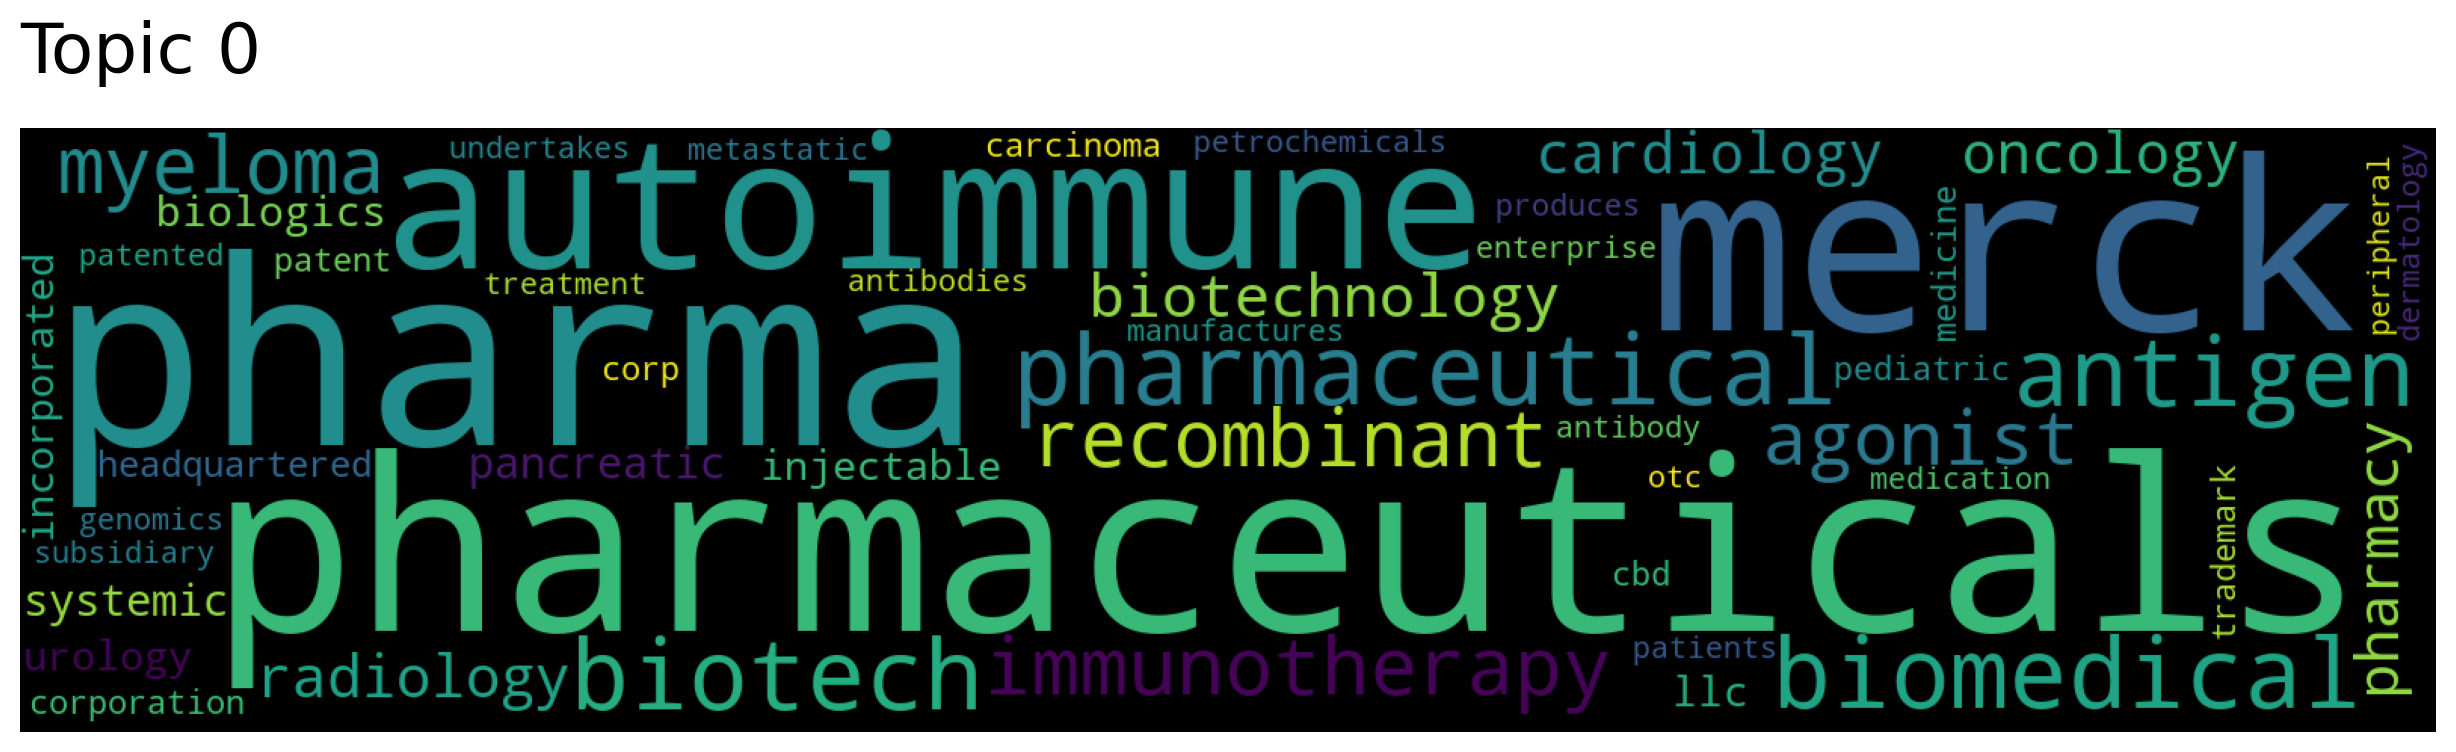

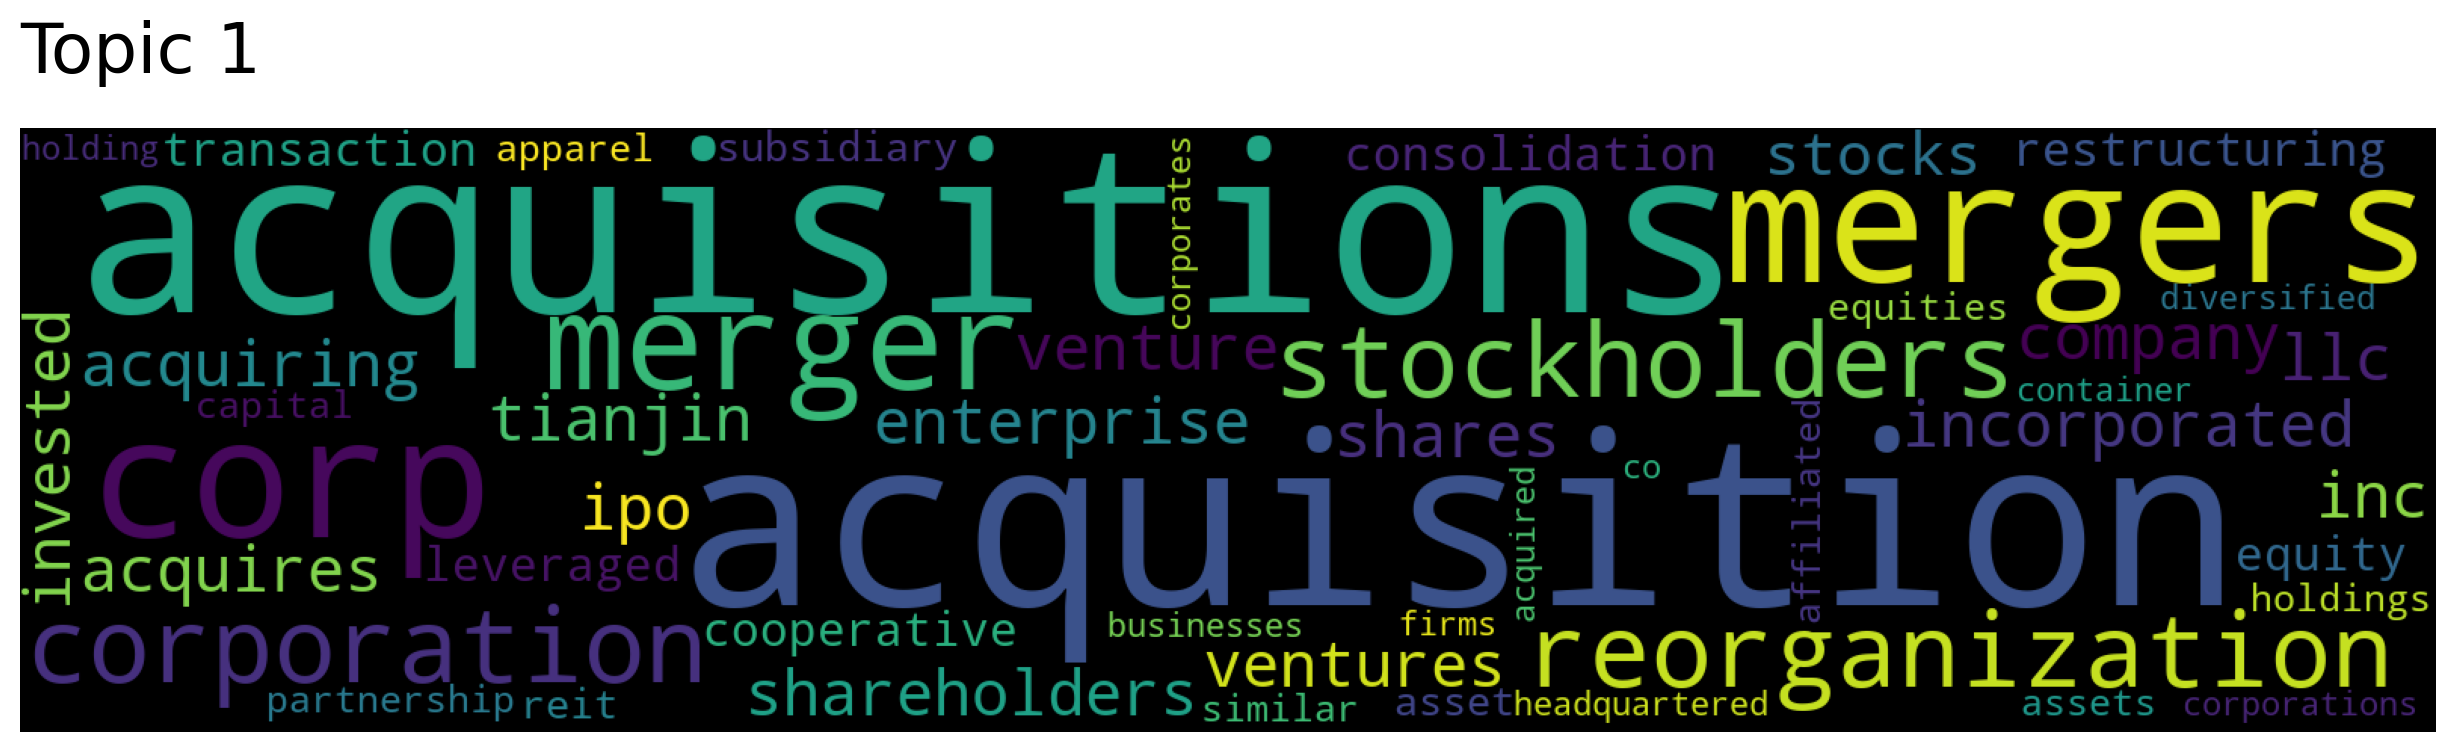

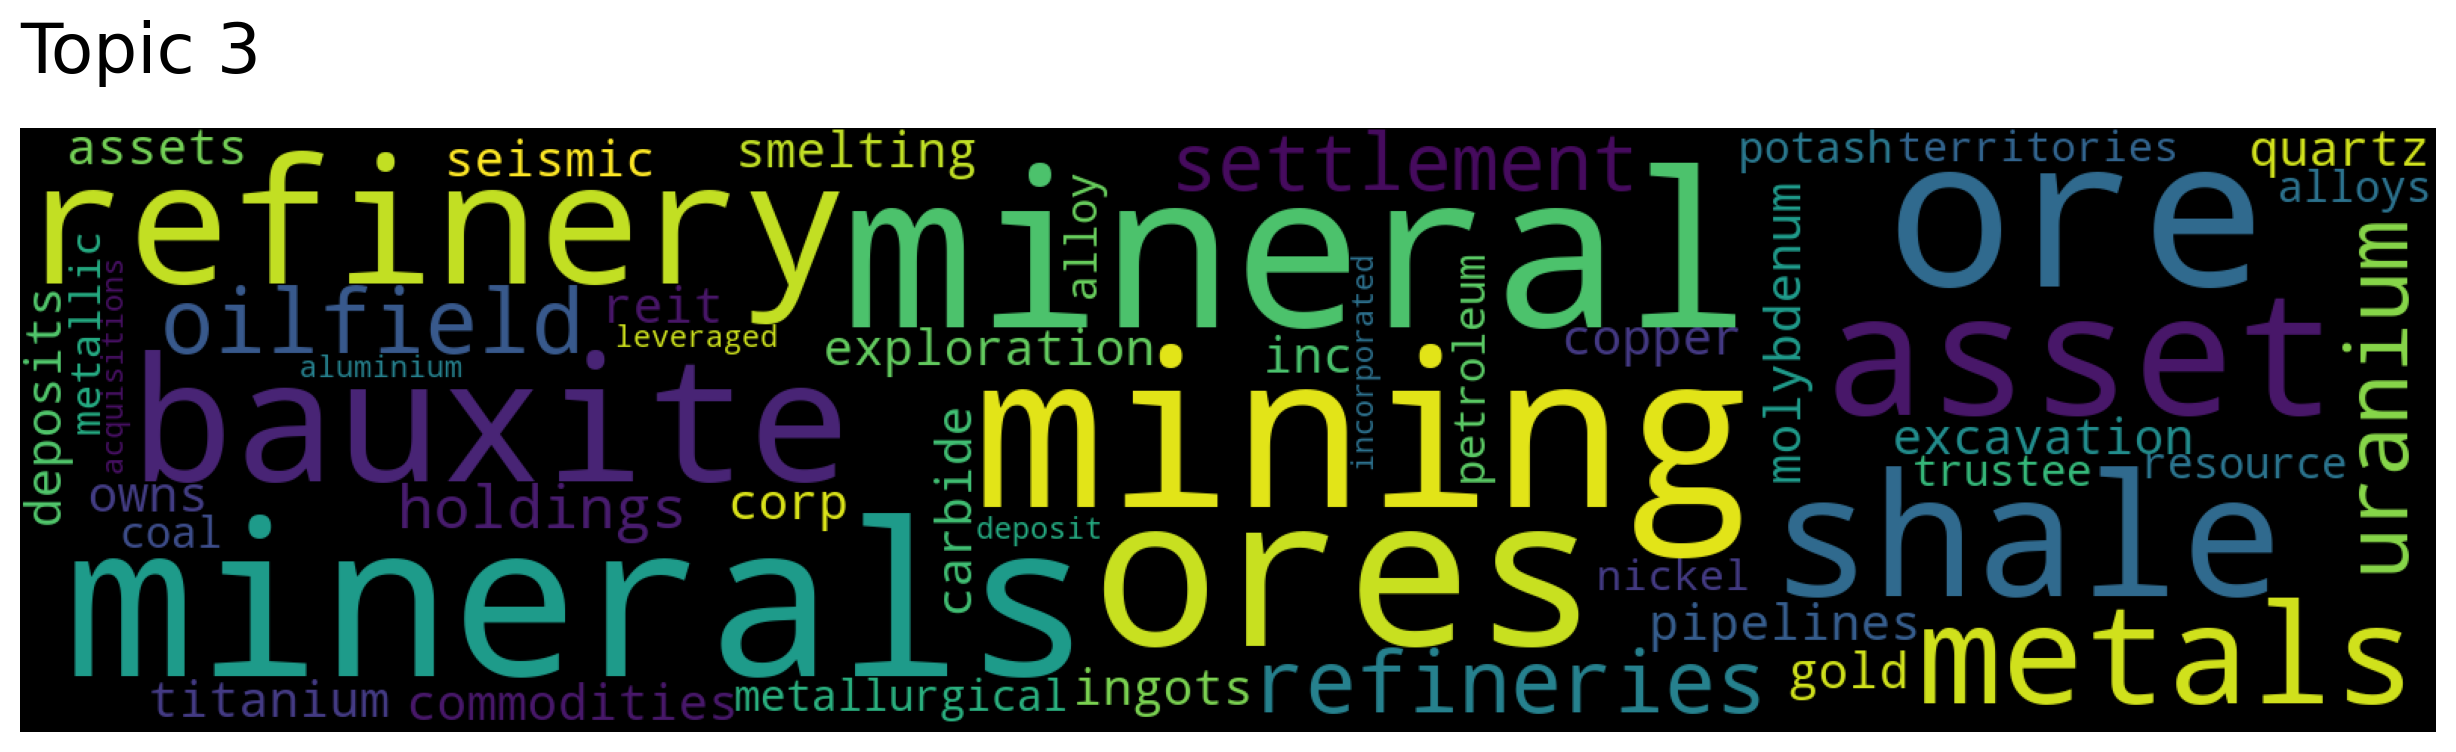

In [ ]:
for topic in range(5):
  t2v.generate_topic_wordcloud(topic)

Let's check Tesla again, in that case we got much more reasonable results, the ability of the embadded word and docs in with a better model like BERT is important.
We can see that the model tagged Tesla as a solar company, which is true but it is not the main focus of the company.

But yet, those results are much better then the previos model.

In [ ]:
t2v.search_documents_by_documents(doc_ids=[249],num_docs=10)

(array(['Tesla, Inc. designs, develops, manufactures, leases, and sells electric vehicles, and energy generation and storage systems in the United States, China, Netherlands, Norway, and internationally. The company operates in two segments, Automotive; and Energy Generation and Storage. The Automotive segment offers sedans and sport utility vehicles. It also provides electric powertrain components and systems; and services for electric vehicles through its company-owned service locations, and Tesla mobile service technicians, as well as sells used vehicles. This segment markets and sells its products through a network of company-owned stores and galleries, as well as through its own Website. The Energy Generation and Storage segment offers energy storage products, such as rechargeable lithium-ion battery systems for use in homes, industrial, commercial facilities, and utility grids; and designs, manufactures, installs, maintains, leases, and sells solar energy generation and energy st

One more functionality that we gain from using this model is to search by words. That because the word are aslo have vectorized representation so it easy to treat them as centroids.


In [ ]:
t2v.search_documents_by_keywords(keywords=['electric','vehicle','cars'],keywords_neg=['part','railway' ],num_docs=6)

(array(['EVgo Inc. owns and operates a direct current fast-charging network for battery electric vehicles in the United States. As of May 5, 2021, it operated approximately 800 DCFC locations in approximately 65 metropolitan areas across 34 states serving approximately 250,000 private and commercial electric vehicle drivers. The company was founded in 2010 and is based in Los Angeles, California.',
        'Maruti Suzuki India Limited manufactures, purchases, and sells motor vehicles, components, and spare parts primarily in India, rest of Asia, Europe, Africa, Oceania, and Latin America. The company offers passenger vehicles, multi utility vehicles, and multi-purpose vehicles. It is also involved in the facilitation of pre-owned car sales, fleet management, and car financing. In addition, the company offers driving school, accessories, insurance, auto card, pre-owned car, and financing products and services. As of May 28, 2020, it had a network of 3,086 showrooms across 1,964 towns an

# BerTopic

BerTopic is an additional algorithem that deals with topic modeling, the steps here are similar to top2vec algorithem, with few differences.

1. Documents embedding using BERT 


2. Reduce dimensional embedding of document vectors using UMAP.


3. Find dense areas of documents using HDBSCAN.


4. Extract and reduce topics with c-TF-IDF


5. Improve coherence of words with Maximal Marginal Relevance


In [ ]:
descriptions = list(companies_profiles.iloc[:]['description'].values)

In [ ]:
bt = BERTopic(calculate_probabilities=True)

In [ ]:
topics, probs = bt.fit_transform(descriptions)

DEBUG:filelock:Attempting to acquire lock 139856536568336 on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/.gitattributes.lock
DEBUG:filelock:Lock 139856536568336 acquired on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/.gitattributes.lock


Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 139856536568336 on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/.gitattributes.lock
DEBUG:filelock:Lock 139856536568336 released on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/.gitattributes.lock
DEBUG:filelock:Attempting to acquire lock 139856102908880 on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/README.md.lock
DEBUG:filelock:Lock 139856102908880 acquired on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/README.md.lock


Downloading:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 139856102908880 on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/README.md.lock
DEBUG:filelock:Lock 139856102908880 released on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/README.md.lock
DEBUG:filelock:Attempting to acquire lock 139856536702352 on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/config.json.lock
DEBUG:filelock:Lock 139856536702352 acquired on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/config.json.lock


Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 139856536702352 on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/config.json.lock
DEBUG:filelock:Lock 139856536702352 released on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/config.json.lock
DEBUG:filelock:Attempting to acquire lock 139856535667664 on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/config_sentence_transformers.json.lock
DEBUG:filelock:Lock 139856535667664 acquired on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/config_sentence_transformers.json.lock


Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 139856535667664 on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/config_sentence_transformers.json.lock
DEBUG:filelock:Lock 139856535667664 released on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/config_sentence_transformers.json.lock
DEBUG:filelock:Attempting to acquire lock 139856537075408 on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/data_config.json.lock
DEBUG:filelock:Lock 139856537075408 acquired on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/data_config.json.lock


Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 139856537075408 on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/data_config.json.lock
DEBUG:filelock:Lock 139856537075408 released on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/data_config.json.lock
DEBUG:filelock:Attempting to acquire lock 139856536731408 on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/modules.json.lock
DEBUG:filelock:Lock 139856536731408 acquired on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/modules.json.lock


Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 139856536731408 on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/modules.json.lock
DEBUG:filelock:Lock 139856536731408 released on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/modules.json.lock
DEBUG:filelock:Attempting to acquire lock 139856139996752 on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/pytorch_model.bin.lock
DEBUG:filelock:Lock 139856139996752 acquired on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/pytorch_model.bin.lock


Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 139856139996752 on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/pytorch_model.bin.lock
DEBUG:filelock:Lock 139856139996752 released on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/pytorch_model.bin.lock
DEBUG:filelock:Attempting to acquire lock 139856536768912 on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/sentence_bert_config.json.lock
DEBUG:filelock:Lock 139856536768912 acquired on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/sentence_bert_config.json.lock


Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 139856536768912 on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/sentence_bert_config.json.lock
DEBUG:filelock:Lock 139856536768912 released on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/sentence_bert_config.json.lock
DEBUG:filelock:Attempting to acquire lock 139856536702352 on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/special_tokens_map.json.lock
DEBUG:filelock:Lock 139856536702352 acquired on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/special_tokens_map.json.lock


Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 139856536702352 on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/special_tokens_map.json.lock
DEBUG:filelock:Lock 139856536702352 released on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/special_tokens_map.json.lock
DEBUG:filelock:Attempting to acquire lock 139856536768912 on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/tokenizer.json.lock
DEBUG:filelock:Lock 139856536768912 acquired on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/tokenizer.json.lock


Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 139856536768912 on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/tokenizer.json.lock
DEBUG:filelock:Lock 139856536768912 released on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/tokenizer.json.lock
DEBUG:filelock:Attempting to acquire lock 139856536756752 on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/tokenizer_config.json.lock
DEBUG:filelock:Lock 139856536756752 acquired on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/tokenizer_config.json.lock


Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 139856536756752 on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/tokenizer_config.json.lock
DEBUG:filelock:Lock 139856536756752 released on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/tokenizer_config.json.lock
DEBUG:filelock:Attempting to acquire lock 139856536753232 on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/train_script.py.lock
DEBUG:filelock:Lock 139856536753232 acquired on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/train_script.py.lock


Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 139856536753232 on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/train_script.py.lock
DEBUG:filelock:Lock 139856536753232 released on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/train_script.py.lock
DEBUG:filelock:Attempting to acquire lock 139856536756752 on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/vocab.txt.lock
DEBUG:filelock:Lock 139856536756752 acquired on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/vocab.txt.lock


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 139856536756752 on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/vocab.txt.lock
DEBUG:filelock:Lock 139856536756752 released on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/vocab.txt.lock
DEBUG:filelock:Attempting to acquire lock 139856139596048 on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/1_Pooling/config.json.lock
DEBUG:filelock:Lock 139856139596048 acquired on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/1_Pooling/config.json.lock


Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 139856139596048 on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/1_Pooling/config.json.lock
DEBUG:filelock:Lock 139856139596048 released on /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/1_Pooling/config.json.lock


In [ ]:
bt.visualize_topics()

In [ ]:
choosen_description_topic = 72

In [ ]:
indices = [i for i, x in enumerate(topics) if x == choosen_description_topic]
print(len(indices))
companies_profiles.iloc[indices]['description']

40


249      Tesla, Inc. designs, develops, manufactures, l...
3258     Capstone Turbine Corp. develops, manufactures,...
3628     Blink Charging Co., through its subsidiaries, ...
4252     Livent Corporation manufactures and sells perf...
4262     NIO Limited designs, manufactures, and sells e...
4394     CBAK Energy Technology, Inc. engages in the de...
4452     Flux Power Holdings, Inc. engages in the desig...
4549     Niu Technologies designs, manufactures, and se...
5607     Voltalia SA engages in the production of elect...
5830     Electrovaya Inc., together with its subsidiari...
6509     Nikola Corporation operates as an integrated z...
6772     Varta AG, through its subsidiaries, researches...
6903     Tesla, Inc. designs, develops, manufactures, l...
7046     iQ International AG is a Switzerland-based com...
7064     Akasol AG develops, manufactures, and distribu...
7074     Voltabox AG develops, manufactures, and sells ...
7857     Exide Industries Limited designs, manufactures.

In [ ]:
!jupyter nbconvert --execute --to html LDA_company_peers_final_project.ipynb

[NbConvertApp] Converting notebook LDA_company_peers_final_project.ipynb to html
Traceback (most recent call last):
  File "/usr/local/bin/jupyter-nbconvert", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python2.7/dist-packages/jupyter_core/application.py", line 267, in launch_instance
    return super(JupyterApp, cls).launch_instance(argv=argv, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/nbconvert/nbconvertapp.py", line 338, in start
    self.convert_notebooks()
  File "/usr/local/lib/python2.7/dist-packages/nbconvert/nbconvertapp.py", line 508, in convert_notebooks
    self.convert_single_notebook(notebook_filename)
  File "/usr/local/lib/python2.7/dist-packages/nbconvert/nbconvertapp.py", line 479, in convert_single_notebook
    output, resources = self.export_single_notebook(notebook_filename, resources, input_buffer=input_buf